## 置换和拆分 MNIST：持续学习的任务构建和简单策略示例
在这个简短的演示中，我们将展示三个常见的持续学习基准，这几个基准通常用于介绍持续学习，并展示初始的可能计算策略。 

我们将从标准 MNIST 基准开始，然后我们将通过 
- Permuted MNIST 和 
- Split MNIST 

来介绍实际的持续学习设置。

基于： **Python**、**Numpy** 和 **PyTorch**。 

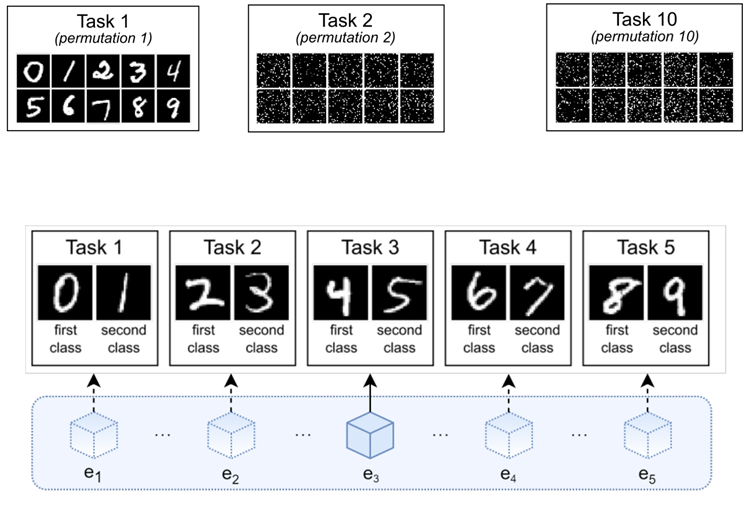


In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# https://www.askpython.com/python/examples/load-and-plot-mnist-dataset-in-python
from scripts import mnist
mnist.init()

Files already downloaded!


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\mnist\MNIST\raw\train-images-idx3-ubyte.gz to data\mnist\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\mnist\MNIST\raw\train-labels-idx1-ubyte.gz to data\mnist\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to data\mnist\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\mnist\MNIST\raw



In [3]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


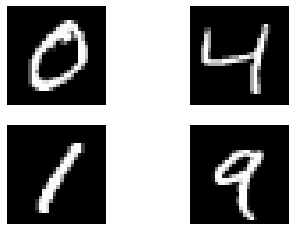

In [4]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

## 定义我们的神经网络，在全集上训练

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [7]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

In [8]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(1, 3):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.761706
Test set: Average loss: 0.0013, Accuracy: 9018/10000 (90%)

Train Epoch: 2 	Loss: 0.487047
Test set: Average loss: 0.0007, Accuracy: 9434/10000 (94%)



## 下面，进行数据集的拆分！

In [9]:
def split_mnist(train_x, train_y, test_x, test_y, n_splits=5):
    """ Given the training set, split the tensors by the class label. """
    n_classes = 10
    if n_classes % n_splits != 0:
        print("n_classes should be a multiple of the number of splits!")
        raise NotImplemented
    class_for_split = n_classes // n_splits
    mnist_train_test = [[],[]]  # train and test
    for id, data_set in enumerate([(train_x, train_y), (test_x, test_y)]):
        for i in range(n_splits):
            start = i * class_for_split
            end = (i + 1) * class_for_split
            split_idxs = np.where(np.logical_and(data_set[1] >= start, data_set[1] < end))[0] #找到当然任务的索引[1,2] [3,4] [5,6] [7,8] [9,10]
            mnist_train_test[id].append((data_set[0][split_idxs], data_set[1][split_idxs]))
    return mnist_train_test

In [10]:
splitmnist = split_mnist(x_train, t_train, x_test, t_test, n_splits=5)
tasks = []
for i in range(5):
    train_split_x, train_split_y = splitmnist[0][i]
    test_split_x, tests_split_y = splitmnist[1][i]
    tasks.append([(train_split_x, train_split_y), (test_split_x, tests_split_y)]) # 构建Tasks列表，打包
    print("train & test splits for task {}: ".format(i))
    print(train_split_x.shape)
    print(train_split_y.shape)
    print(min(train_split_y), max(train_split_y))

train & test splits for task 0: 
(12665, 1, 28, 28)
(12665,)
0 1
train & test splits for task 1: 
(12089, 1, 28, 28)
(12089,)
2 3
train & test splits for task 2: 
(11263, 1, 28, 28)
(11263,)
4 5
train & test splits for task 3: 
(12183, 1, 28, 28)
(12183,)
6 7
train & test splits for task 4: 
(11800, 1, 28, 28)
(11800,)
8 9


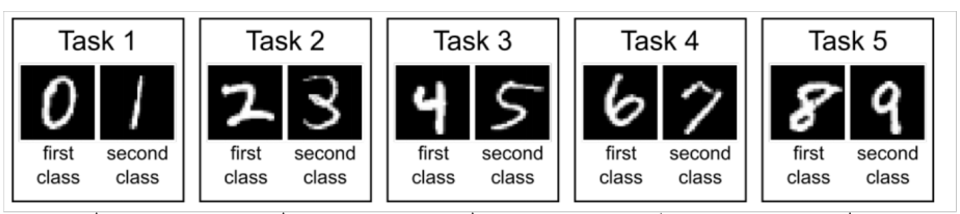


## Naive Training - 不记忆任何知识的训练（每次都只训练新任务）
当数据的分布发生改变时（比如新任务中出现了新的类），这种训练方式必然会产生灾难性的遗忘

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
naive_accs = []

for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task # 给当前Task解包
  
  for epoch in range(1, 2):
    train(model, device, x_train, t_train, optimizer, epoch)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc 
  
  naive_accs.append(avg_acc / len(tasks))
  print("Avg acc: ", avg_acc / len(tasks))

Training on task:  0
Train Epoch: 1 	Loss: 0.047627
Testing on task:  0
Test set: Average loss: 0.0000, Accuracy: 2107/2115 (100%)

Testing on task:  1
Test set: Average loss: 0.0979, Accuracy: 0/2042 (0%)

Testing on task:  2
Test set: Average loss: 0.0968, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: 0.1026, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: 0.0963, Accuracy: 0/1983 (0%)

Avg acc:  19.92434988179669
Training on task:  1
Train Epoch: 1 	Loss: 0.763563
Testing on task:  0
Test set: Average loss: 0.0343, Accuracy: 0/2115 (0%)

Testing on task:  1
Test set: Average loss: 0.0027, Accuracy: 1010/2042 (49%)

Testing on task:  2
Test set: Average loss: 0.0307, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: 0.0293, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: 0.0291, Accuracy: 0/1983 (0%)

Avg acc:  9.892262487757101
Training on task:  2
Train Epoch: 1 	Loss: 0.989875
Testing on task:  0
Test set:

## Cumulative Training - 积累式学习的策略

另一个简单的 CL 想法是继续 *全部* 或 *部分* 先前遇到的示例（以前的任务），将它们与当前任务的数据打乱。 使用 *全部* 过去的数据接近我们在任务序列结束时可以期望的最佳性能，但代价是更大的内存使用量。

In [12]:
# 混合之前的N个Task
def shuffle_in_unison(dataset, seed, in_place=False):
    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

In [13]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
cumul_accs = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task
  
  # for previous task
  for i in range(id):
    (past_x_train, past_t_train), _ = tasks[i]
    x_train = np.concatenate((x_train, past_x_train))
    t_train = np.concatenate((t_train, past_t_train))
  
  x_train, t_train = shuffle_in_unison([x_train, t_train], 0) # 之前的所有Task中的数据
  
  for epoch in range(1, 2):
    train(model, device, x_train, t_train, optimizer, epoch)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / len(tasks))
  cumul_accs.append(avg_acc / len(tasks))

Training on task:  0
Train Epoch: 1 	Loss: 0.104507
Testing on task:  0
Test set: Average loss: 0.0001, Accuracy: 2105/2115 (100%)

Testing on task:  1
Test set: Average loss: 0.0864, Accuracy: 0/2042 (0%)

Testing on task:  2
Test set: Average loss: 0.0799, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: 0.0851, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: 0.0848, Accuracy: 0/1983 (0%)

Avg acc:  19.905437352245862
Training on task:  1
Train Epoch: 1 	Loss: 0.403578
Testing on task:  0
Test set: Average loss: 0.0005, Accuracy: 2070/2115 (98%)

Testing on task:  1
Test set: Average loss: 0.0013, Accuracy: 1853/2042 (91%)

Testing on task:  2
Test set: Average loss: 0.0435, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: 0.0477, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: 0.0420, Accuracy: 0/1983 (0%)

Avg acc:  37.723341738387475
Training on task:  2
Train Epoch: 1 	Loss: 0.328989
Testing on task:  0
Tes

## Joint Training - 联合训练策略

在每一个任务中，所有数据都在训练过程中可见，这其实模拟了普通的Classical Training设置。 因此，这并**不是一个持续学习所允许的策略**，不过，它提供了持续学习问题的性能上限，是一个我们需要试图去接近的基线Benchmark。

In [14]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
offline_accs = []

print("Training on all tasks together...")
avg_acc = 0
(x_train, t_train), _ = tasks[0]
  
for i in range(1, len(tasks)):
    (past_x_train, past_t_train), _ = tasks[i]
    x_train = np.concatenate((x_train, past_x_train))
    t_train = np.concatenate((t_train, past_t_train))
  
x_train, t_train = shuffle_in_unison([x_train, t_train], 0)

for epoch in range(1, 4):
    train(model, device, x_train, t_train, optimizer, epoch)
    
for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
print("Avg acc: ", avg_acc / len(tasks))
for i in range(len(tasks)):
    offline_accs.append(avg_acc/ len(tasks))

Training on all tasks together...
Train Epoch: 1 	Loss: 0.559224
Train Epoch: 2 	Loss: 0.251164
Train Epoch: 3 	Loss: 0.178701
Testing on task:  0
Test set: Average loss: 0.0002, Accuracy: 2089/2115 (99%)

Testing on task:  1
Test set: Average loss: 0.0006, Accuracy: 1943/2042 (95%)

Testing on task:  2
Test set: Average loss: 0.0006, Accuracy: 1788/1874 (95%)

Testing on task:  3
Test set: Average loss: 0.0004, Accuracy: 1920/1986 (97%)

Testing on task:  4
Test set: Average loss: 0.0009, Accuracy: 1841/1983 (93%)

Avg acc:  95.76985062429641


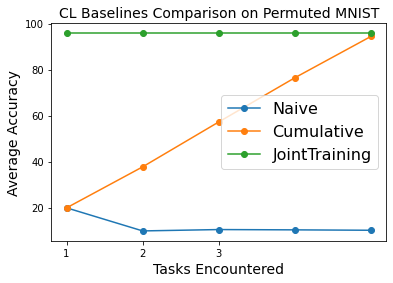

In [15]:
plt.plot([1, 2, 3, 4, 5], naive_accs, '-o', label="Naive")
plt.plot([1, 2, 3, 4, 5], cumul_accs, '-o', label="Cumulative")
plt.plot([1, 2, 3, 4, 5], offline_accs, '-o', label="JointTraining")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Baselines Comparison on Permuted MNIST', fontsize=14);
plt.xticks([1, 2, 3])
plt.legend(prop={'size': 16});